<a id='section_6'></a>
## *5.*Image Super-resolution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard
import os

if not os.path.isdir('./HypernetworkSiren'):
  !git clone https://github.com/ZrbTz/HypernetworkSiren.git
  !bash -c 'mv ./HypernetworkSiren/* ./'
  !bash -c 'rmdir ./HypernetworkSiren'


from hypersiren import *

Cloning into 'HypernetworkSiren'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 42091 (delta 41), reused 55 (delta 24), pack-reused 42017
Receiving objects: 100% (42091/42091), 4.06 GiB | 49.43 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Checking out files: 100% (1878/1878), done.
rmdir: failed to remove './HypernetworkSiren': Directory not empty


In [ ]:
def grid_search(datasetPath, writer, width_LR=64, height_LR=64, factor=4, hidden_features = 256, hidden_layers = 3):
  # set variables
  better_params = (30,30,2e-4,0.1)
  best_PSNR = 0

  # grid search
  '''
  for first_omega in [30,50,80,100]:
    for hidden_omega in [30,50,80,100]:
      for lr in [2e-4, 1e-4]:
        for hidden_layer in [3, 5, 7]:'''
  for first_omega in [20, 30, 50, 80, 100]:
    for hidden_omega in [20, 30, 50, 80, 100]:
      for lr in [5e-4, 2e-4, 1e-4, 5e-5]:
        for hidden_layer in [2, 3, 5, 7]:
        #instantiate data loader with a single batch (we have only one image)
          dataloader_LR = DataLoader(ImageFittingRGB_grad(datasetPath, width_LR, height_LR, factor), batch_size=1, pin_memory=True, num_workers=0, shuffle=False)
          #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
          #number of output features = 3 (y RGB value), hidden features, hidden layers
          #and if to have the last layer as a linear layer or not
          
          img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, 
                            hidden_layers=hidden_layer, first_omega_0=first_omega, hidden_omega_0=hidden_omega)

          img_siren.cuda()

          coords_LR, coords_HR, pixels_LR, pixels_HR, pixels_LR_original, grad, _, filename = next(iter(dataloader_LR))
          coords_LR, pixels_LR, grad = coords_LR.cuda(), pixels_LR.cuda(), grad.cuda()
          train_grad(img_siren, coords_LR, pixels_LR, grad, name = os.path.basename(filename[0]), writer = writer,lr =  lr)
          '''train(img_siren, dataloader_LR, lr = lr,  size=img_size)'''
        
          #super resolution test
          coords_HR = coords_HR.cuda()
          pixels_HR = pixels_HR.cuda()
          siren_output, siren_coords = img_siren(coords_HR)

          # computing PSNR SIREN
          PSNR_SIREN = psnr(pixels_HR, siren_output)
          print('first_omega_0: {}, hidden_omega_0: {}, lr: {}, hidden_layer: {}, PSNR:{}, Best:{}'.format(first_omega,hidden_omega,lr,hidden_layer,PSNR_SIREN,best_PSNR))
          if PSNR_SIREN > best_PSNR:
            best_PSNR = PSNR_SIREN
            better_params = (first_omega,hidden_omega,lr,hidden_layer)

  return better_params

def grid_search_reg(datasetPath, writer, width_LR=64, height_LR=64, factor=4, L1 = False, L2 = False, L_grad = False):
  # set variables
  better_params = (3, 128, 0.0005)
  best_PSNR = 0
  first_omega = 30
  hidden_omega = 30
  # grid search
  '''
  for hidden_layers in [3, 5, 8, 10]:
    for hidden_features in [128, 256, 512]:
      for reg_lambda in [0.00005, 0.0001, 0.0005, 0.001]:'''
  for hidden_layers in [2, 3, 5, 8, 10]:
    for hidden_features in [64, 128, 256, 512]:
      for reg_lambda in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]:
        #instantiate data loader with a single batch (we have only one image)
        dataloader_LR = DataLoader(ImageFittingRGB_grad(datasetPath, width_LR, height_LR, factor), batch_size=1, pin_memory=True, num_workers=0, shuffle=False)
        #instantiate siren net with number of input features = 2 ((x1,x2) pairs),
        #number of output features = 3 (y RGB value), hidden features, hidden layers
        #and if to have the last layer as a linear layer or not
        img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=hidden_features, 
                            hidden_layers=hidden_layers, first_omega_0=first_omega, hidden_omega_0=hidden_omega)

        img_siren.cuda()

        coords_LR, coords_HR, pixels_LR, pixels_HR, pixels_LR_original, grad, _, filename = next(iter(dataloader_LR))
        coords_LR, pixels_LR, grad = coords_LR.cuda(), pixels_LR.cuda(), grad.cuda()
        train_grad(img_siren, coords_LR, pixels_LR, grad, name = os.path.basename(filename[0]), writer = writer, 
                       L1 = L1, L2 = L2, L_grad = L_grad, reg_lambda = reg_lambda)
      
        #super resolution test
        coords_HR = coords_HR.cuda()
        pixels_HR = pixels_HR.cuda()
        siren_output, siren_coords = img_siren(coords_HR)

        # computing PSNR SIREN
        PSNR_SIREN = psnr(pixels_HR, siren_output)
        print('hidden_layers: {}, hidden_features: {}, reg_lambda: {}, PSNR:{}, Best:{}'.format(hidden_layers,hidden_features,reg_lambda,PSNR_SIREN,best_PSNR))
        if PSNR_SIREN > best_PSNR:
          best_PSNR = PSNR_SIREN
          better_params = (hidden_layers, hidden_features, reg_lambda)

  return better_params


In [ ]:
datasetPath = "/content/images/Set14"
checkpoint_path = "/content/drive/MyDrive/backup_training/SIREN_GRID_Search_im.chk"
writer_folder = "/content/drive/MyDrive/backup_training/SIREN_GRID_Search_im"
width_LR = 64
height_LR = 64
factor = 4
width_HR = width_LR * factor
height_HR = height_LR * factor
writer = SummaryWriter(writer_folder)

In [ ]:
# GRID SEARCH on basic parameter
better_params_best = grid_search(datasetPath = datasetPath, writer=writer, width_LR=width_LR, height_LR=height_LR)
print(better_params_best)

first_omega_0: 20, hidden_omega_0: 20, lr: 0.0005, hidden_layer: 2, PSNR:17.903617536955366, Best:0
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0005, hidden_layer: 3, PSNR:17.964727953980947, Best:17.903617536955366
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0005, hidden_layer: 5, PSNR:17.96418019802925, Best:17.964727953980947
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0005, hidden_layer: 7, PSNR:17.516975774806653, Best:17.964727953980947
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0002, hidden_layer: 2, PSNR:17.907883813998637, Best:17.964727953980947
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0002, hidden_layer: 3, PSNR:17.96093659052957, Best:17.964727953980947
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0002, hidden_layer: 5, PSNR:18.02761296160356, Best:17.964727953980947
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0002, hidden_layer: 7, PSNR:17.94082775153701, Best:18.02761296160356
first_omega_0: 20, hidden_omega_0: 20, lr: 0.0001, hidden_layer: 2, PSNR:17.7969143648

In [ ]:
#GRID SEARCH changing net structure and using L1 normalization
better_params_best_L1 = grid_search_reg(datasetPath,  writer = writer, width_LR=width_LR, height_LR=height_LR, L1 = True)
print(better_params_best_L1)

hidden_layers: 2, hidden_features: 64, reg_lambda: 1e-05, PSNR:17.343842957481442, Best:0
hidden_layers: 2, hidden_features: 64, reg_lambda: 5e-05, PSNR:17.20506186064869, Best:17.343842957481442
hidden_layers: 2, hidden_features: 64, reg_lambda: 0.0001, PSNR:17.110161931650737, Best:17.343842957481442
hidden_layers: 2, hidden_features: 64, reg_lambda: 0.0005, PSNR:16.25316565394041, Best:17.343842957481442
hidden_layers: 2, hidden_features: 64, reg_lambda: 0.001, PSNR:15.868578547447145, Best:17.343842957481442
hidden_layers: 2, hidden_features: 128, reg_lambda: 1e-05, PSNR:17.813871726422956, Best:17.343842957481442
hidden_layers: 2, hidden_features: 128, reg_lambda: 5e-05, PSNR:17.604806168442888, Best:17.813871726422956
hidden_layers: 2, hidden_features: 128, reg_lambda: 0.0001, PSNR:17.40729200933836, Best:17.813871726422956
hidden_layers: 2, hidden_features: 128, reg_lambda: 0.0005, PSNR:16.486260748334484, Best:17.813871726422956
hidden_layers: 2, hidden_features: 128, reg_lambd

In [ ]:
# GRID SEARCH changing net structure and using L2 normalization
better_params_best_L2 = grid_search_reg(datasetPath, writer = writer, width_LR=width_LR, height_LR=height_LR, L2 = True, )
print(better_params_best_L2)

hidden_layers: 3, hidden_features: 128, reg_lambda: 5e-05, PSNR:25.551729821790616, Best:0
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.0001, PSNR:25.524813265733993, Best:25.551729821790616
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.0005, PSNR:25.444283723651168, Best:25.551729821790616
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.001, PSNR:25.31832373563967, Best:25.551729821790616
hidden_layers: 3, hidden_features: 256, reg_lambda: 5e-05, PSNR:25.695678746211847, Best:25.551729821790616
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.0001, PSNR:25.671233053677014, Best:25.695678746211847
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.0005, PSNR:25.60120223850266, Best:25.695678746211847
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.001, PSNR:25.493217067905114, Best:25.695678746211847
hidden_layers: 3, hidden_features: 512, reg_lambda: 5e-05, PSNR:25.795998709951743, Best:25.695678746211847
hidden_layers: 3, hidden_features: 512, reg

In [ ]:
# GRID SEARCH changing net structure and using grad Loss
better_params_best_LossGrad = grid_search_reg(datasetPath, writer = writer, width_LR=width_LR, height_LR=height_LR, L_grad = True)
print(better_params_best_LossGrad)

hidden_layers: 3, hidden_features: 128, reg_lambda: 5e-05, PSNR:24.402451685759893, Best:0
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.0001, PSNR:24.17761096042821, Best:24.402451685759893
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.0005, PSNR:23.180036330805844, Best:24.402451685759893
hidden_layers: 3, hidden_features: 128, reg_lambda: 0.001, PSNR:22.171066892810245, Best:24.402451685759893
hidden_layers: 3, hidden_features: 256, reg_lambda: 5e-05, PSNR:24.89520347513235, Best:24.402451685759893
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.0001, PSNR:24.85694131596898, Best:24.89520347513235
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.0005, PSNR:24.683778417377994, Best:24.89520347513235
hidden_layers: 3, hidden_features: 256, reg_lambda: 0.001, PSNR:24.291045802991995, Best:24.89520347513235
hidden_layers: 3, hidden_features: 512, reg_lambda: 5e-05, PSNR:25.10638978347448, Best:24.89520347513235
hidden_layers: 3, hidden_features: 512, reg_lambd

In [ ]:
# SUPER RESOLUTION TEST
#standard value
#better_params = (30, 30, 1e-4, 2, 256, False, False, False, 0)
# Grid search hyperparams fixed net structure
better_params = (20, 100, 1e-4, 3, 256, False, False, False, 0)
# L1 norm
#better_params = (30, 30, 1e-4, 8, 128, True, False, False, 5e-05)
# L2 norm
#better_params = (30, 30, 1e-4, 5, 512, False, True, False, 0.0001)
# Gradient Loss
#better_params = (30, 30, 1e-4, 8, 256, False, False, True, 5e-05)
# load real image
dataloader_LR = DataLoader(ImageFittingRGB_grad(datasetPath, width_LR, height_LR, factor), batch_size=1, pin_memory=True, num_workers=0, shuffle=False)

# train SIREN
img_siren = Basic_Siren(in_features=2, out_features=3, hidden_features=better_params[4], 
                  hidden_layers=better_params[3], first_omega_0=better_params[0], hidden_omega_0=better_params[1])
img_siren.cuda()

#coords_LR, coords_HR, pixels_LR, pixels_HR, pixels_LR_original, self.grads_LR, self.laplace_LR, filename
model_input, _ , ground_truth, _ , _ , grad, _, filename = next(iter(dataloader_LR))
model_input, ground_truth, grad = model_input.cuda(), ground_truth.cuda(), grad.cuda()
train_grad(img_siren, model_input, ground_truth, grad, name = os.path.basename(filename[0]), writer = writer, lr =  better_params[2], gamma = 0.1,
               L1 = better_params[5], L2 = better_params[6], L_grad = better_params[7], width = width_LR, height = height_LR, reg_lambda = better_params[8])

In [ ]:
#writer.close()
%tensorboard --logdir {writer_folder}

CUDA-0 used memory [1707008 bytes / 15812263936 bytes (0.01%)]
torch.Size([256, 256, 3])
/content/images/Set14/ppt3.png
Running on GPU 0


./srgan/models/weight_inits.py:101: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  _get_init_fn(weight_init)(m.weight.data)
./srgan/models/weight_inits.py:103: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(bias_init)(m.bias.data)
./srgan/models/weight_inits.py:101: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(weight_init)(m.weight.data)


Restored checkpoint from srgan/resources/pretrained/srgan.pth


./srgan/training/base_runner.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = [Variable(tensor, volatile=volatile) for tensor in batch]


Running on GPU 0
Restored checkpoint from srgan/resources/pretrained/srresnet.pth


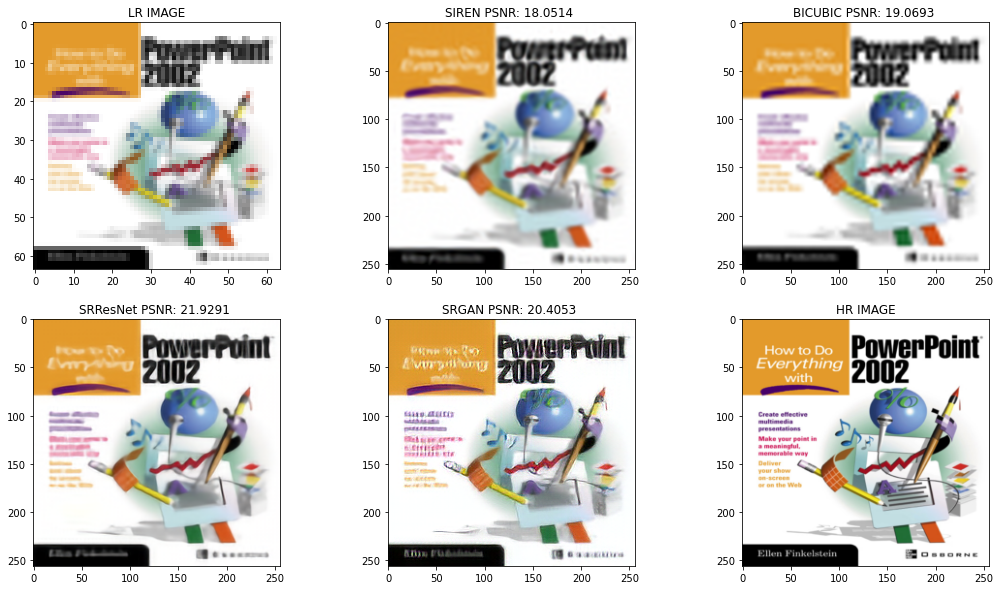

In [ ]:
import copy
print_CUDA_memory_statistics()
max_test_images = 14

# load real image
test_dataloader = DataLoader(TestImageFitting_RGB(datasetPath, width_LR, height_LR, factor, max = max_test_images), batch_size=1, pin_memory=True, num_workers=0, shuffle=False)
input_grid_LR, input_grid_HR, ground_truth_HR, ground_truth_LR, _, filename = next(iter(test_dataloader))

input_grid_LR = input_grid_LR.cuda()
input_grid_HR = input_grid_HR.cuda()
ground_truth_HR = ground_truth_HR.cuda()
ground_truth_LR = ground_truth_LR.cuda()

# computing PSNR SIREN
siren_output_HR, _ = img_siren(input_grid_HR)
psnr_siren = psnr(target = ground_truth_HR, input = siren_output_HR)

# computing PSNR BICUBIC
print(get_bicubic_image(filename[0], width_LR, height_LR, width_HR, height_HR).permute(1, 2, 0).shape)
bicubic_output = get_bicubic_image(filename[0], width_LR, height_LR, width_HR, height_HR).permute(1, 2, 0).view(-1, 3)
bicubic_output = bicubic_output.cuda()
psnr_bicubic = psnr(target = ground_truth_HR, input = bicubic_output)

# Save temp image for SRGAN and SRResNet
save_image(ground_truth_LR.squeeze().view(height_LR, width_LR, 3).permute(2, 0, 1), 'srgan/pred/tmp.png', nrow=4)

from srgan import eval

# computing PSNR SRGAN
model = "srgan" 
print(filename[0])
argv = ["-i", "srgan/configs/" + model + ".json", "srgan/resources/pretrained/" + model + ".pth", 'srgan/pred/tmp.png']
eval.main(argv)
!bash -c 'mv ./srgan/pred/tmp_pred.png ./srgan/pred/img_srgan.png'
srgan = get_image_tensor("./srgan/pred/img_srgan.png",height_LR=height_HR, width_LR=width_HR, factor=1)[0].permute(1, 2, 0).view(-1, 3)
srgan = srgan.cuda()
psnr_srgan = psnr(target = ground_truth_HR, input = srgan)

# computing PSNR SRResNet
model = "srresnet" 
argv = ["-i", "srgan/configs/" + model + ".json", "srgan/resources/pretrained/" + model + ".pth", 'srgan/pred/tmp.png']
eval.main(argv)
!bash -c 'mv ./srgan/pred/tmp_pred.png ./srgan/pred/img_srresnet.png'
srresnet = get_image_tensor("./srgan/pred/img_srresnet.png",height_LR=height_HR, width_LR=width_HR, factor=1)[0].permute(1, 2, 0).view(-1, 3)
srresnet = srresnet.cuda()
psnr_srresnet = psnr(target = ground_truth_HR, input = srresnet)

# PLOT result
fig, axes = plt.subplots(2,3, figsize=(18,10))
axes[0,0].set_title("LR IMAGE")
axes[0,0].imshow(ground_truth_LR.cpu().view(height_LR, width_LR, 3).detach().numpy())
axes[0,1].set_title("SIREN PSNR: %0.4f " % psnr_siren)
axes[0,1].imshow(torch.clamp(siren_output_HR.cpu(), min=0, max=1).view(height_HR, width_HR, 3).detach().numpy())
axes[0,2].set_title("BICUBIC PSNR: %0.4f " % psnr_bicubic)
axes[0,2].imshow(bicubic_output.cpu().view(height_HR, width_HR,3).detach().numpy())

axes[1,0].set_title("SRResNet PSNR: %0.4f " % psnr_srresnet)
axes[1,0].imshow(srresnet.cpu().view(height_HR, width_HR,3).detach().numpy())
axes[1,1].set_title("SRGAN PSNR: %0.4f " % psnr_srgan)
axes[1,1].imshow(srgan.cpu().view(height_HR, width_HR,3).detach().numpy())
axes[1,2].set_title("HR IMAGE")
axes[1,2].imshow(ground_truth_HR.cpu().view(height_HR, width_HR,3).detach().numpy())


plt.show()
